### Import libraries

In [42]:
import pandas
import numpy as np
import matplotlib.pyplot as plt
import seaborn
import os
import sys
import argparse

### Import stations and their coordinates

In [43]:
data_path = "./data/1991-2005/monthly/"
station_df = pandas.read_csv("./data/1991-2005/tmy3/TMY3_StationsMeta(1).csv")

### Define functions

In [44]:
## Helpers
# Function to calculate solar declination angle (delta)
def solar_declination(day_of_year):
    return 23.45 * np.sin(np.deg2rad((360 / 365) * (day_of_year - 81)))

# Function to calculate the solar elevation angle (alpha)
def solar_elevation_angle(latitude, solar_declination, hour_angle):
    return np.arcsin(np.sin(np.deg2rad(latitude)) * np.sin(np.deg2rad(solar_declination)) +
                     np.cos(np.deg2rad(latitude)) * np.cos(np.deg2rad(solar_declination)) * np.cos(np.deg2rad(hour_angle)))

# Function to calculate solar azimuth angle (A)
def solar_azimuth_angle(latitude, solar_declination, solar_elevation):
    numerator = np.sin(np.deg2rad(solar_declination)) - np.sin(np.deg2rad(solar_elevation)) * np.sin(np.deg2rad(latitude))
    denominator = np.cos(np.deg2rad(solar_elevation)) * np.cos(np.deg2rad(latitude))
    azimuth = np.rad2deg(np.arccos(numerator / denominator))
    return azimuth

# Function to calculate the maximum azimuth angle at sunrise or sunset
def max_azimuth(latitude, longitude, day_of_year):
    declination = solar_declination(day_of_year)
    # Approximate hour angle at sunset or sunrise (sun at horizon)
    solar_elevation = 0  # at sunrise/sunset
    max_azimuth = 180 - np.rad2deg(np.arctan(-np.sin(np.deg2rad(latitude)) * np.cos(np.deg2rad(declination)) / np.sin(np.deg2rad(declination))))
    
    # Optionally: adjust azimuth based on time zone (longitude affects solar time)
    time_offset = (longitude / 15.0)  # Time zone adjustment based on longitude (degrees to hours)
    return max_azimuth



In [45]:
# Function to merge the data of the stations with the coordinates
def merge_a_station(path, elevation, longitude, latitude):
    # Define a n empty dataframe
    merged_df = pandas.DataFrame()

    # For each csv file in the folder
    for file in os.listdir(path):
        if file.endswith(".csv") and file != "merged.csv":
            # Read the csv file
            data = pandas.read_csv(path + file)
            
            # Add the elevation, longitude and latitude
            data['Elevation'] = elevation
            data['Longitude'] = longitude
            data['Latitude'] = latitude
            
            # Seperate the year_month column into 2 seperate columns
            data['year_month'] = data['year_month'].astype(str)
            data['Year'] = data['year_month'].str[:4]
            data['Month'] = data['year_month'].str[5:]
            
            
            # Remove the year_month column
            data = data.drop(columns=['year_month'])
            
            # Calculate the azimuth(apply maximum azimuth with the (month-1)*30 + 17)
            data['Azimuth (deg)'] = data.apply(lambda x: max_azimuth(latitude, longitude, (int(x['Month'])-1)*30 + 17), axis=1)
            
            
            # Merge the data with the stations
            merged_df = pandas.concat([merged_df, data], axis=0) 

    merged_df.reset_index(drop=True).to_csv(path + "merged.csv", index=False)
    
    print("Station " + path + " merged")
    
# Function to merge the stations
def merge_stations(path):
    # Find all the folders in the path
    folders = [f for f in os.listdir(path) if os.path.isdir(os.path.join(path, f))]
    
    # Define the empty dataframe
    merged_df = pandas.DataFrame()
    
    # For each station
    for station in folders:
        # Define the path of the folder
        station_path = path + station + "/" + "merged.csv"
        
        if not os.path.exists(station_path):
            continue
            
        # Read the csv file
        data = pandas.read_csv(station_path)
        
        # Merge the data with the stations
        merged_df = pandas.concat([merged_df, data], axis=0) 

    merged_df = merged_df.reset_index(drop=True).to_csv(path + "solar_dataset.csv", index=False)
        


### Merge te data

In [46]:
# Find all the folders in the path
folders = [f for f in os.listdir(data_path) if os.path.isdir(os.path.join(data_path, f))]

# For each station
for station in folders:
    try:
        # Take station coordinates
        elevation = station_df[station_df["USAF"] == int(station)]["Elev"].values[0]
        longitude = station_df[station_df["USAF"] == int(station)]["Longitude"].values[0]
        latitude = station_df[station_df["USAF"] == int(station)]["Latitude"].values[0]
    except:
        logg = open("log.txt", "a")
        logg.write("Station " + station + " not found\n")
        logg.close()
        continue
    
    # Define the path of the folder
    station_path = data_path + station + "/"
    
    # Merge the data
    merge_a_station(station_path, elevation, longitude, latitude)
    
# Merge all the stations
merge_stations(data_path)
 

Station ./data/1991-2005/monthly/690150/ merged
Station ./data/1991-2005/monthly/690190/ merged
Station ./data/1991-2005/monthly/690230/ merged
Station ./data/1991-2005/monthly/699604/ merged
Station ./data/1991-2005/monthly/700197/ merged
Station ./data/1991-2005/monthly/700260/ merged
Station ./data/1991-2005/monthly/700637/ merged
Station ./data/1991-2005/monthly/701043/ merged
Station ./data/1991-2005/monthly/701195/ merged
Station ./data/1991-2005/monthly/701330/ merged
Station ./data/1991-2005/monthly/701625/ merged
Station ./data/1991-2005/monthly/701718/ merged
Station ./data/1991-2005/monthly/701740/ merged
Station ./data/1991-2005/monthly/701780/ merged
Station ./data/1991-2005/monthly/701940/ merged
Station ./data/1991-2005/monthly/702000/ merged
Station ./data/1991-2005/monthly/702005/ merged
Station ./data/1991-2005/monthly/702035/ merged
Station ./data/1991-2005/monthly/702040/ merged
Station ./data/1991-2005/monthly/702070/ merged
Station ./data/1991-2005/monthly/702075/

In [47]:
import pandas
import numpy
data_path = "./data/1991-2005/monthly/"

In [48]:
df = pandas.read_csv(data_path + "solar_dataset.csv")

In [49]:
df.head()

,Merged Glo (Wh/m^2),Merged Dir (Wh/m^2),Merged Dif (Wh/m^2),Precip Wat (cm),AOD (unitless),Ozone (cm),Albedo (unitless),Zenith (deg),Azimuth (deg),Precip Wat Flg,AOD Flg,Ozone Flg,Albedo Flg,Elevation,Longitude,Latitude,Year,Month
0,90864.0,136948.0,32805.0,1.239,0.042,0.310,0.19,99.0,124.146427,1,2,0,0,626,-116.167,34.3,1991,1
1,100911.0,122387.0,38863.0,1.346,0.045,0.296,0.20,99.0,112.205505,1,2,0,0,626,-116.167,34.3,1991,2
2,159306.0,193529.0,46571.0,1.131,0.061,0.349,0.17,99.0,92.861450,1,2,0,0,626,-116.167,34.3,1991,3
3,189448.0,193036.0,58825.0,1.347,0.099,0.333,0.19,99.0,252.377722,1,2,0,0,626,-116.167,34.3,1991,4
4,240458.0,269441.0,53039.0,1.431,0.088,0.353,0.20,99.0,238.194014,1,2,0,0,626,-116.167,34.3,1991,5


In [50]:
df.describe()

,Merged Glo (Wh/m^2),Merged Dir (Wh/m^2),Merged Dif (Wh/m^2),Precip Wat (cm),AOD (unitless),Ozone (cm),Albedo (unitless),Zenith (deg),Azimuth (deg),Precip Wat Flg,AOD Flg,Ozone Flg,Albedo Flg,Elevation,Longitude,Latitude,Year,Month
count,183576.000000,183576.000000,1.835760e+05,183576.000000,183576.000000,183576.000000,183576.000000,183576.000000,183576.000000,183576.000000,183576.000000,183576.000000,183576.0,183576.000000,183576.000000,183576.000000,183576.000000,183576.000000
mean,120287.348956,125059.870599,-8.573230e+33,1.881639,0.120836,0.323072,0.186031,98.994710,179.518288,2.491459,1.174533,0.284743,0.0,377.978886,-98.556875,40.089230,1998.000065,6.500000
std,59662.979931,58190.287205,9.816870e+35,1.039726,0.058699,0.039581,0.080516,0.235644,68.435261,6.449332,0.450448,3.802010,0.0,488.836952,25.694479,8.436195,4.320478,3.452062
min,0.000000,0.000000,-1.124171e+38,0.175000,0.019000,0.227000,0.080000,86.300000,91.703083,1.000000,1.000000,0.000000,0.0,-34.000000,-176.650000,13.483000,1991.000000,1.000000
25%,72002.750000,86968.000000,3.138100e+04,1.062000,0.076000,0.295000,0.150000,99.000000,113.950819,1.000000,1.000000,0.000000,0.0,47.000000,-111.383000,34.767000,1994.000000,3.750000
50%,122742.000000,125135.500000,4.970650e+04,1.629000,0.110000,0.318000,0.170000,99.000000,179.935065,1.000000,1.000000,0.000000,0.0,216.500000,-94.717000,39.883500,1998.000000,6.500000
75%,169393.500000,160146.000000,6.836825e+04,2.517000,0.153000,0.345000,0.190000,99.000000,245.017887,3.000000,1.000000,0.000000,0.0,414.000000,-83.417000,43.900000,2002.000000,9.250000
max,268277.000000,360938.000000,1.686050e+05,5.999000,0.514000,0.521000,0.690000,99.000000,267.236214,53.000000,3.000000,55.000000,0.0,3026.000000,174.117000,71.320000,2005.000000,12.000000


In [51]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 183576 entries, 0 to 183575
Data columns (total 18 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   Merged Glo (Wh/m^2)  183576 non-null  float64
 1   Merged Dir (Wh/m^2)  183576 non-null  float64
 2   Merged Dif (Wh/m^2)  183576 non-null  float64
 3   Precip Wat (cm)      183576 non-null  float64
 4   AOD (unitless)       183576 non-null  float64
 5   Ozone (cm)           183576 non-null  float64
 6   Albedo (unitless)    183576 non-null  float64
 7   Zenith (deg)         183576 non-null  float64
 8   Azimuth (deg)        183576 non-null  float64
 9   Precip Wat Flg       183576 non-null  int64  
 10  AOD Flg              183576 non-null  int64  
 11  Ozone Flg            183576 non-null  int64  
 12  Albedo Flg           183576 non-null  int64  
 13  Elevation            183576 non-null  int64  
 14  Longitude            183576 non-null  float64
 15  Latitude         

In [52]:
# Print all latitude values
print(df['Latitude'].unique())

[34.3   32.433 48.35  32.65  66.6   71.32  70.2   68.35  66.267 66.883
 68.133 67.1   66.917 65.167 66.567 64.517 62.067 63.683 63.783 63.883
 62.65  62.783 60.367 61.517 60.783 65.7   62.95  61.583 61.983 62.317
 60.583 60.467 64.55  62.883 58.083 64.817 64.65  64.    62.15  61.25
 61.183 61.217 61.6   61.417 61.133 60.767 60.117 62.967 60.5   60.817
 57.167 55.2   55.317 59.05  58.683 56.95  59.75  61.717 59.65  59.467
 57.75  59.517 58.417 57.05  58.35  56.967 56.8   56.483 55.367 55.05
 52.717 51.883 53.9   24.55  24.583 24.733 25.817 25.9   26.067 25.483
 25.65  26.683 26.15  26.2   28.117 27.65  28.433 28.55  29.167 29.183
 28.783 30.5   30.233 30.4   30.333 32.117 32.9   32.483 27.483 27.767
 26.583 26.533 27.967 27.383 27.9   27.983 31.533 31.25  31.15  30.38
 29.7   30.783 32.683 32.633 33.367 33.633 33.767 33.867 30.483 30.35
 30.717 30.683 30.633 30.2   32.35  32.517 32.3   32.383 31.867 31.233
 31.267 33.917 33.567 32.616 33.967 33.217 33.583 30.    30.033 30.05
 29.817 30.

In [53]:
# Print the maximum azimuth for all the rows that has latitude 34.3
print(df[df['Latitude'] == 18.5]['Azimuth (deg)'].max())

261.7987073653281


### Corelation matrix

E:\Users\mukoi\anaconda3\envs\tf\lib\site-packages\seaborn\matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


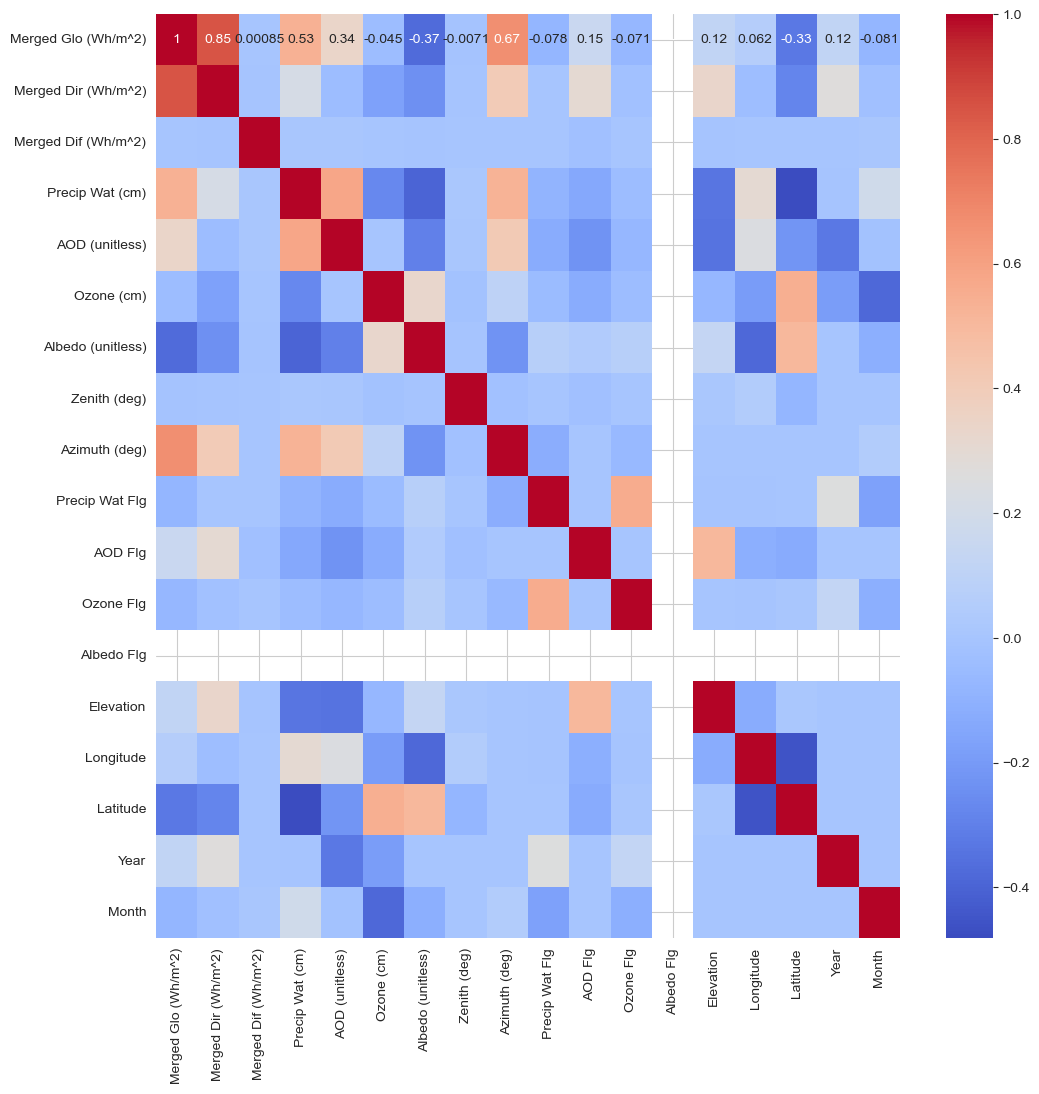

In [54]:
correlation_matrix = df.corr()
plt.figure(figsize=(12, 12))
seaborn.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.show()